In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
import tqdm
import io

In [0]:
# Print datasets metrics and description
def analyze_dataframe(dataframe):
    print(dataframe.head())
    print(dataframe.count())
    print(dataframe.describe())


In [0]:
# Remove rows that only contain 0
def clean_rows(dataframe):
    non_zero_dataframe = dataframe[(dataframe.T != 0).any()]
    print('Number of rows that have all 0s: ' + str(dataframe.shape[0] - non_zero_dataframe.shape[0]))
    return non_zero_dataframe

In [0]:
# Remove outliers
def remove_outliers_0(dataframe):
    dataframe_new = feature_selection(dataframe, 2)

    dataframe_remove_0 = dataframe_new.sort_values(by=[0])[-12:]
    dataframe_remove_1 = dataframe_new.sort_values(by=[1])[-3:]
    
    visualize_data(dataframe_new)
    
    row_names = list(set(list(dataframe_remove_0.index) + list(dataframe_remove_1.index)))

    dataframe = dataframe[~dataframe.index.isin(row_names)]

    return dataframe

In [0]:
# Remove outliers
def remove_outliers_1(dataframe):
    dataframe_new = feature_selection(dataframe, 3)

    dataframe_remove_1 = dataframe_new.sort_values(by=[1])[-3:]
    dataframe_remove_2 = dataframe_new.sort_values(by=[2])[-1:]
    
    visualize_data(dataframe_new)

    row_names = list(set(list(dataframe_remove_1.index) + list(dataframe_remove_2.index)))

    dataframe = dataframe[~dataframe.index.isin(row_names)]

    return dataframe

In [0]:
# Remove outliers
def remove_outliers_2(dataframe):
    dataframe_new = feature_selection(dataframe, 3)

    dataframe_remove_2 = dataframe_new.sort_values(by=[2])[-1:]

    row_names = list(dataframe_remove_2.index)

    dataframe = dataframe[~dataframe.index.isin(row_names)]

    return dataframe

In [0]:
  # Standardize dataset z = (x - u) / s
def standardize_dataset(dataframe):
    x = dataframe.values
    standard_scaler = StandardScaler()
    x_standardized = standard_scaler.fit_transform(x)
    return pd.DataFrame(x_standardized, index=dataframe.index.values)


In [0]:
def normalize_dataset(dataframe):
    x = dataframe.values
    x = normalize(x, 'max')
    return pd.DataFrame(x, index=dataframe.index.values)

In [0]:
# Reduce dimensionality to n_feature features
def feature_selection(dataframe, n_components=3, svd_solver='auto'):
    pca = PCA(n_components=n_components, svd_solver=svd_solver)

    x = dataframe.values
    x = pca.fit_transform(x)

    return pd.DataFrame(x, index=dataframe.index.values)

In [0]:
# Visualize data if it has 3 or 2 dimensions
def visualize_data(dataframe, c=None, cmap=None):
    x = dataframe.values
    if dataframe.shape[1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=c, cmap=cmap)
        plt.savefig('3d.png')
        plt.show()
    elif dataframe.shape[1] == 2:
        plt.scatter(x[:, 0], x[:, 1], c=c, cmap=cmap)
        plt.savefig('2d.png')
        plt.show()

In [0]:
def visualize_dendogram(dataframe):
    dataframe_new = dataframe.sample(50)
    x = dataframe_new.values

    linked = linkage(x, 'single')

    labelList = list(dataframe_new.index)

    plt.figure(figsize=(10, 7))
    dendrogram(linked,
               orientation='top',
               labels=labelList,
               distance_sort='descending',
               show_leaf_counts=True)
    plt.show()

In [0]:
def preprocess(dataframe, i):
    print(dataframe.shape)
    analyze_dataframe(dataframe)
    
    dataframe = clean_rows(dataframe)

    if i == 'original':
        daataframe = standardize_dataset(dataframe)
    else:
        dataframe = normalize_dataset(dataframe)
        
    if i == 'original':
        dataframe_new = feature_selection(dataframe, 3)
        x = dataframe_new.values
        plt.scatter(x[:, 0], x[:, 1], x[:, 2])
        dataframe = remove_outliers_0(dataframe)
        dataframe = remove_outliers_1(dataframe)
        dataframe = remove_outliers_2(dataframe)
    
    dataframe_2_dim = feature_selection(dataframe, 2)

    dataframe_3_dim = feature_selection(dataframe, 3)

    dataframe_95_variance = feature_selection(dataframe, 0.95, 'full')

    print(dataframe_95_variance.shape)

    visualize_data(dataframe_2_dim)

    visualize_data(dataframe_3_dim)

    visualize_dendogram(dataframe_2_dim)

    return dataframe_95_variance

In [0]:
# TODO; Save best and do 3 dims on it
def hierarchical_clustering(dataframe):
    x = dataframe.values
  
    configs = []
  
    params = [{'n_clusters': 2, 'affinity': 'euclidean', 'linkage': 'ward'},
              {'n_clusters': 3, 'affinity': 'euclidean', 'linkage': 'ward'},
              {'n_clusters': 4, 'affinity': 'euclidean', 'linkage': 'ward'}]
    for n_clusters in [2, 3, 4]:
      for affinity in ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']:
        for linkage in ['complete', 'average', 'single']:
          params.append({'n_clusters': n_clusters, 'affinity': affinity, 'linkage': linkage})
  
    for config in tqdm.tqdm_notebook(params):
      cluster = AgglomerativeClustering(n_clusters=config['n_clusters'], affinity=config['affinity'], linkage=config['linkage'])
      cluster.fit_predict(x)

      configs.append({'model': cluster, 'silhouette': silhouette_score(x, cluster.labels_)})

    x_2_dim = feature_selection(dataframe, 2).values
    
    fig = plt.figure()   
    
    for i in range(len(configs)):      
      plt.scatter(x_2_dim[:, 0], x_2_dim[:, 1], c=configs[i]['model'].labels_, cmap='rainbow')
      plt.savefig('hc_' + str(i) + '_' + str(configs[i]['silhouette']) + '.png')


In [0]:
# TODO; Save best and do 3 dims on it
def DBSCAN_clustering(dataframe):
    x = dataframe.values
    
    configs = []
    
    params = []
    for metric in ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']:
      for eps in [16, 32, 48, 64]:
        for min_samples in [16, 32, 48, 64]:
          params.append({'metric': metric, 'eps': eps, 'min_samples': min_samples})
 
    for config in tqdm.tqdm_notebook(params):
      cluster = DBSCAN(eps=config['eps'], min_samples=config['min_samples'], metric=config['metric'])
      cluster.fit_predict(x)
      
      try:
        configs.append({'model': cluster, 'silhouette': silhouette_score(x, cluster.labels_),
                        'metric': config['metric'], 'eps': config['eps'], 'min_samples': config['min_samples']})
      except:
        continue
        
    x_2_dim = feature_selection(dataframe, 2).values

    fig = plt.figure()   
    for i in range(len(configs)):
      plt.scatter(x_2_dim[:, 0], x_2_dim[:, 1], c=configs[i]['model'].labels_, cmap='rainbow')
      plt.savefig('dbscan_' + str(i) + '_' + str(configs[i]['silhouette']) + '.png')

In [0]:
def cluster(dataframe):
    # Do for number of different n_clusters and distances...
    #hierarchical_clustering(dataframe)
    DBSCAN_clustering(dataframe)

(31221, 1339)
               1  2  3  4  5  6  7  ...  1333  1334  1335  1336  1337  1338  1339
hg38_A1BG      0  0  0  0  0  0  0  ...     0     0     0     0     0     0     1
hg38_A1BG-AS1  0  0  0  0  0  0  0  ...     0     0     0     0     0     0     0
hg38_A1CF      0  0  0  0  0  0  0  ...     0     0     0     0     0     0     0
hg38_A2M       0  0  0  0  0  0  0  ...     0     0     0     1     0     0     0
hg38_A2M-AS1   0  0  0  0  0  0  0  ...     0     0     0     0     0     0     0

[5 rows x 1339 columns]
1       31221
2       31221
3       31221
4       31221
5       31221
6       31221
7       31221
8       31221
9       31221
10      31221
11      31221
12      31221
13      31221
14      31221
15      31221
16      31221
17      31221
18      31221
19      31221
20      31221
21      31221
22      31221
23      31221
24      31221
25      31221
26      31221
27      31221
28      31221
29      31221
30      31221
        ...  
1310    31221
1311    31221
1312   

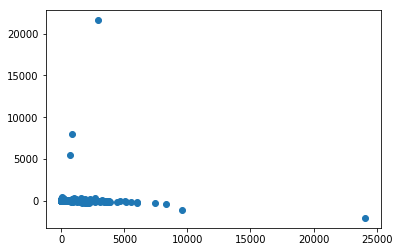

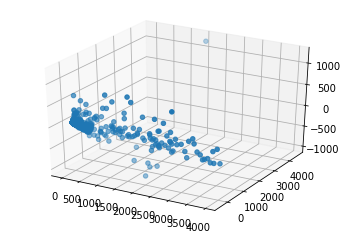

(17563, 8)


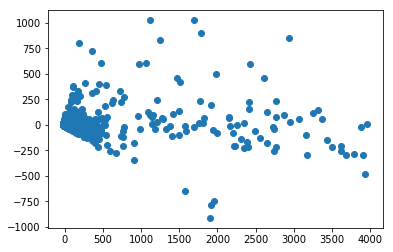

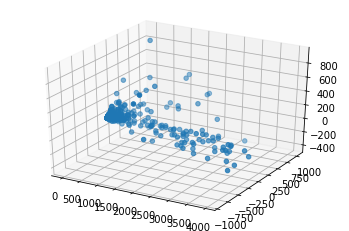

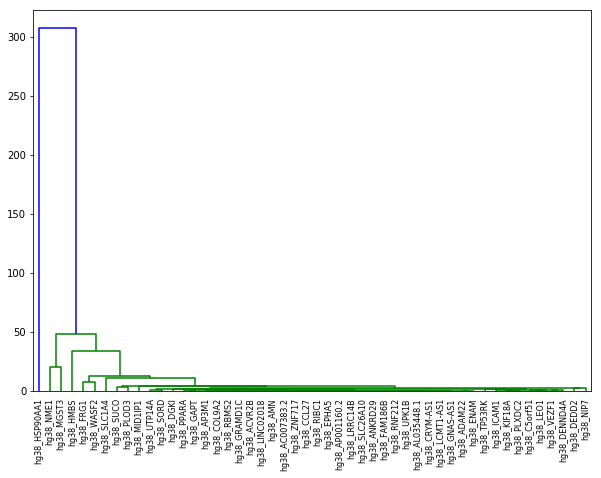

(1339, 31221)
   hg38_A1BG  hg38_A1BG-AS1  hg38_A1CF  ...  hg38_ZYG11B  hg38_ZYX  hg38_ZZEF1
1          0              0          0  ...            0         0           0
2          0              0          0  ...            0         0           0
3          0              0          0  ...            0         0           0
4          0              0          0  ...            0         1           0
5          0              0          0  ...            0         0           0

[5 rows x 31221 columns]
hg38_A1BG           1339
hg38_A1BG-AS1       1339
hg38_A1CF           1339
hg38_A2M            1339
hg38_A2M-AS1        1339
hg38_A2ML1          1339
hg38_A2ML1-AS1      1339
hg38_A2ML1-AS2      1339
hg38_A3GALT2        1339
hg38_A4GALT         1339
hg38_A4GNT          1339
hg38_AAAS           1339
hg38_AACS           1339
hg38_AADAC          1339
hg38_AADACL2        1339
hg38_AADACL2-AS1    1339
hg38_AADACL3        1339
hg38_AADACL4        1339
hg38_AADAT          1339
hg38_AAED1 

KeyboardInterrupt: ignored

In [0]:
dataframe = pd.read_csv('data/023_Multiple_myeloma_from _he_bone_marrow_from_MM135_patients_csv.csv',
                            header=0, index_col=0)

for i, (df, ty) in enumerate([(dataframe, 'original'), (dataframe.transpose(), 'transpose')]):
    df = preprocess(df, ty)
    #cluster(df)

In [0]:
from google.colab import files
import os

for file in os.listdir('.'):
  if file[:2] == 'hc' or file[:2] == 'db':
    files.download(file)

In [0]:
fac